<a href="https://colab.research.google.com/github/albinwan/algorithmic-trading-python/blob/master/02_EDA_and_Pre_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

Import libraries and set default settings

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.stats import ttest_ind
from datetime import datetime
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from scipy.spatial.distance import cdist
from geopy.distance import geodesic

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

# some matplotlib params to make the defaults more readable
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['font.size'] = 15
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

sns.set_theme(context='talk', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)

Read in datasets

In [2]:
test = pd.read_csv('../data_clean/test.csv')
train = pd.read_csv('../data_clean/train.csv')
weather = pd.read_csv('../data_clean/weather.csv')
spray = pd.read_csv('../data_clean/spray.csv')

Check the shapes of datasets

In [3]:
print("test.csv shape: ", test.shape)
print("train.csv shape: ", train.shape)
print("weather.csv shape: ", weather.shape)
print("spray.csv shape: ", spray.shape)

test.csv shape:  (116293, 29)
train.csv shape:  (8475, 30)
weather.csv shape:  (1472, 22)
spray.csv shape:  (14294, 4)


## Edits prior to train/validation split 

Adding in columns to differentiate the date features (year-mth/year/month/week):

In [4]:
train['Date'] = pd.to_datetime(train['Date'])
train['year-mth']= pd.to_datetime(train['Date']).apply(lambda x: '{}-{:02d}'.format(x.year, x.month))
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Week'] = train['Date'].dt.week

test['Date'] = pd.to_datetime(test['Date'])
test['year-mth']= pd.to_datetime(test['Date']).apply(lambda x: '{}-{:02d}'.format(x.year, x.month))
test['Year'] = test['Date'].dt.year
test['Month'] = test['Date'].dt.month
test['Week'] = test['Date'].dt.week

<ipython-input-4-9cec6075a479>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train['Week'] = train['Date'].dt.week
<ipython-input-4-9cec6075a479>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  test['Week'] = test['Date'].dt.week


# Train/validation split

We will be converting our dataset from A to B, creating a validation set to validate how well our model performs.

![](https://upload.wikimedia.org/wikipedia/commons/b/bb/ML_dataset_training_validation_test_sets.png)

For the sake of EDA purposes we will not drop `WnvPresent` from train yet. Instead we will do this at a later stage.

In [5]:
X = train
y = train['WnvPresent']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

# Imputation

We found null values for `StnPressure`, which we will inpute with the median.

In [6]:
X_train.isnull().sum().sort_values(ascending=False).head()

StnPressure    54
Week            0
WnvPresent      0
DewPoint        0
Depart          0
dtype: int64

In [7]:
X_train['StnPressure'].fillna(X_train['StnPressure'].median(), inplace=True)

/Users/nglynette/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


We will also make the same imputations on validation and test set with values from our train set in order to prevent data leakage.

In [8]:
X_val['StnPressure'].fillna(X_train['StnPressure'].median(), inplace=True)
test['StnPressure'].fillna(X_train['StnPressure'].median(), inplace=True)

# EDA

In [9]:
for col in X_train:
    print(f'{col} column count of unique values: {len(X_train[col].unique())}')

Date column count of unique values: 95
Trap column count of unique values: 136
Latitude column count of unique values: 138
Longitude column count of unique values: 138
Species column count of unique values: 7
Block column count of unique values: 145
AddressAccuracy column count of unique values: 43
NumMosquitos column count of unique values: 193
WnvPresent column count of unique values: 2
Tmax column count of unique values: 33
Tmin column count of unique values: 48
Tavg column count of unique values: 64
Depart column count of unique values: 28
DewPoint column count of unique values: 32
WetBulb column count of unique values: 31
Sunrise column count of unique values: 62
Sunset column count of unique values: 58
CodeSum column count of unique values: 19
PrecipTotal column count of unique values: 30
StnPressure column count of unique values: 58
SeaLevel column count of unique values: 41
ResultSpeed column count of unique values: 62
ResultDir column count of unique values: 34
AvgSpeed column

In [10]:
X_train.dtypes

Date               datetime64[ns]
Trap                       object
Latitude                  float64
Longitude                 float64
Species                    object
Block                       int64
AddressAccuracy             int64
NumMosquitos                int64
WnvPresent                  int64
Tmax                        int64
Tmin                      float64
Tavg                      float64
Depart                    float64
DewPoint                    int64
WetBulb                   float64
Sunrise                     int64
Sunset                      int64
CodeSum                    object
PrecipTotal               float64
StnPressure               float64
SeaLevel                  float64
ResultSpeed               float64
ResultDir                   int64
AvgSpeed                  float64
Heat/Cool                 float64
sunset                     object
sunrise                    object
SunHours                  float64
isRainy                     int64
Humidity      

In [11]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Latitude,5678.0,41.845055,0.106624,41.644612,41.750498,41.862292,41.944869,42.017430
Longitude,5678.0,-87.694506,0.084245,-87.930995,-87.752411,-87.694991,-87.642984,-87.531635
Block,5678.0,44.176647,34.935900,10.000000,17.000000,39.000000,61.000000,540.000000
AddressAccuracy,5678.0,9.609898,9.738965,3.000000,8.000000,8.000000,9.000000,306.000000
NumMosquitos,5678.0,15.340085,65.413410,1.000000,2.000000,4.000000,11.000000,2207.000000
WnvPresent,5678.0,0.053892,0.225825,0.000000,0.000000,0.000000,0.000000,1.000000
Tmax,5678.0,81.280733,8.338156,57.000000,78.000000,83.000000,87.000000,96.000000
Tmin,5678.0,63.143625,7.589431,42.500000,59.000000,64.500000,69.000000,77.500000
Tavg,5678.0,72.212179,7.499392,50.750000,68.000000,73.500000,78.000000,84.750000
Depart,5678.0,2.497534,6.611005,-12.000000,-2.000000,3.500000,7.000000,18.000000


## West Nile Virus

Let's look at what's the percentage of the full population that contains the West Nile Virus:

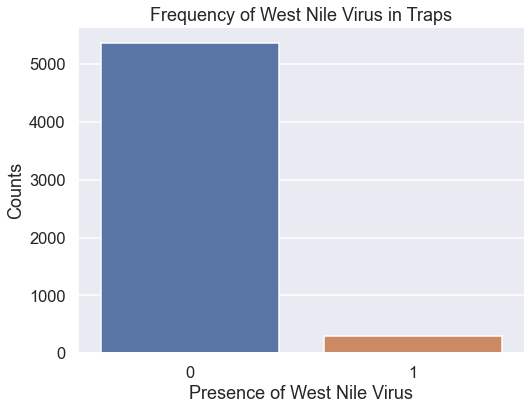

In [12]:
wnv_count = pd.DataFrame(X_train['WnvPresent'].value_counts())

sns.barplot(x=wnv_count.index, y=wnv_count['WnvPresent'])
plt.title('Frequency of West Nile Virus in Traps')
plt.xlabel('Presence of West Nile Virus')
plt.ylabel('Counts');

In [13]:
X_train['WnvPresent'].value_counts(normalize=True)

0    0.946108
1    0.053892
Name: WnvPresent, dtype: float64

Approximately 5% of our train data set contains the West Nile Virus. Considering the imbalance of occurences, an option we may consider is to use SMOTE as a part of our modelling technique, which we will explore in the modelling section.

We will also take a look at how the presence of West Nile Virus trends across weeks and months.

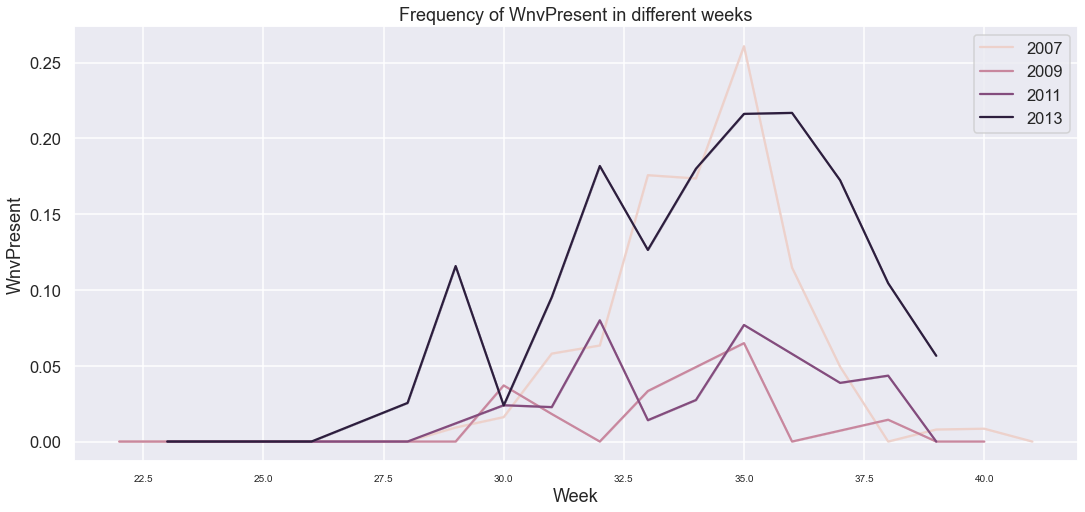

In [14]:
plt.figure(figsize=(18,8))
sns.lineplot(x = "Week", y = "WnvPresent", data = X_train, ci=False, hue='Year')
plt.legend()
plt.xticks(fontsize=10);
plt.title('Frequency of WnvPresent in different weeks');

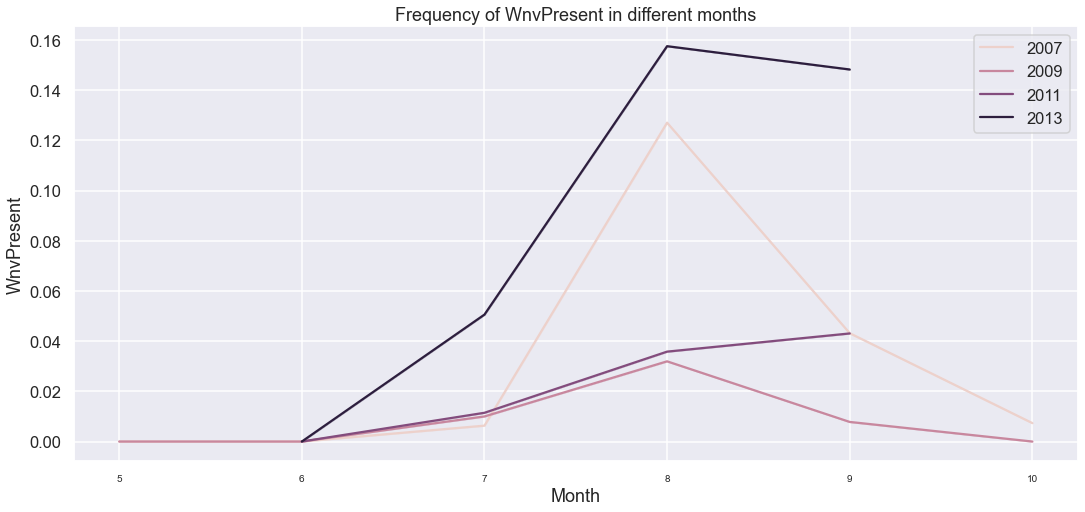

In [15]:
plt.figure(figsize=(18,8))
sns.lineplot(x = "Month", y = "WnvPresent", data = X_train, ci=False, hue='Year')
plt.legend()
plt.xticks(fontsize=10);
plt.title('Frequency of WnvPresent in different months');

Occurence of West Nile Virus seem to be high during the month of August.

Text(0.5, 1.0, 'Number of Mosquitos in different year-mth')

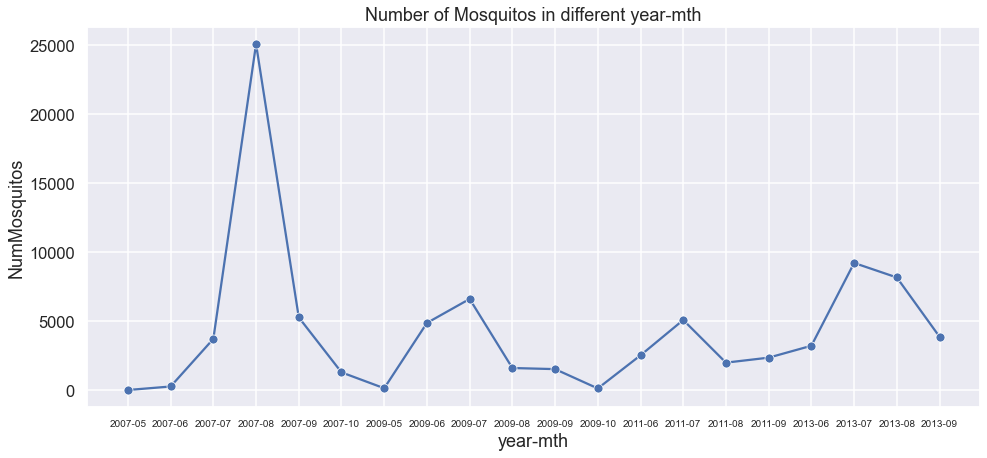

In [16]:
yrmth_group = X_train.groupby(['year-mth']).sum()

plt.figure(figsize=(16,7))
sns.lineplot(x = yrmth_group.index  , y = "NumMosquitos", data = yrmth_group ,marker='o', ci=False)
plt.xticks(fontsize=10);
plt.title('Number of Mosquitos in different year-mth')
#need to reduce the tick size... no space lol

Similarly, above is also showing spikes in the number of mosquitoes during July/August period.

## Number of mosquitoes

We take a look at the yearly count of mosquitoes as well as the count of West Nile Virus by year.

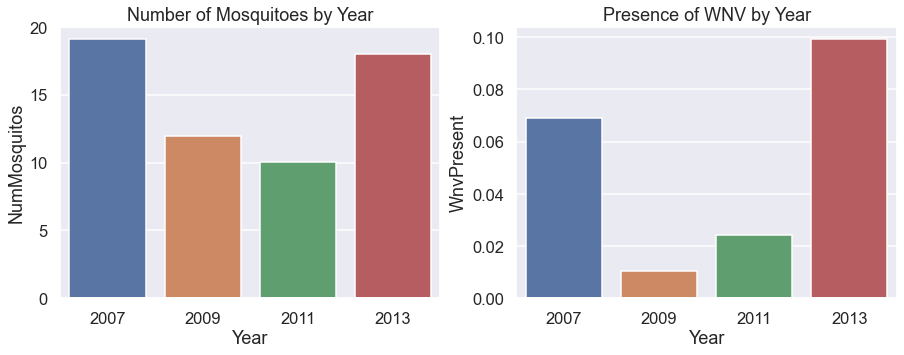

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5));

sns.barplot(ax=axes[0], x = 'Year', y= 'NumMosquitos', data=X_train, ci=False);
axes[0].set_title("Number of Mosquitoes by Year");


sns.barplot(ax=axes[1], x = 'Year', y= 'WnvPresent', data=X_train, ci=False);
axes[1].set_title("Presence of WNV by Year");

`NumMosquitos` with `WnvPresent` peaks in July 2007 but does not show a similar trend to `NumMosquitos` without `WnvPresent` for July in years: 2009, 2011 and 2013.

## Species

We want to take a look at data for mosquito species to see if there are any specific breeds which have a higher tendency to harbour the West Nile Virus

In [18]:
species_eda = X_train[['Species', 'NumMosquitos', 'WnvPresent']].groupby('Species').sum()
species_eda['WnvPresent_Pct'] = species_eda['WnvPresent'] / species_eda['NumMosquitos'] * 100
species_eda = species_eda.sort_values(by='WnvPresent', ascending=False)
species_eda

,NumMosquitos,WnvPresent,WnvPresent_Pct
Species,,,
CULEX PIPIENS/RESTUANS,45309,146,0.322232
CULEX PIPIENS,25768,127,0.492859
CULEX RESTUANS,15625,33,0.211200
CULEX ERRATICUS,7,0,0.000000
CULEX SALINARIUS,97,0,0.000000
CULEX TARSALIS,2,0,0.000000
CULEX TERRITANS,293,0,0.000000


It looks like the bulk of the breeds captured belong to either Culex Restuans or Culex Pipiens. It also looks like there's a group of species which may be either Pipiens or Restauns, or a hybrid of Pipiens and Restauns.

Text(0.5, 0, 'Count')

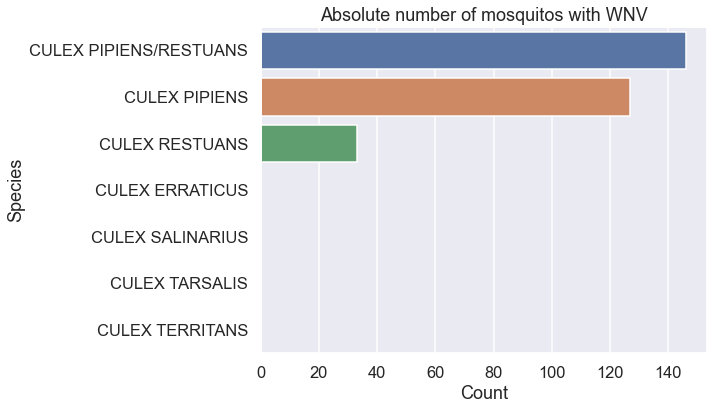

In [19]:
sns.barplot(data=species_eda, y=species_eda.index, x=species_eda['WnvPresent'], orient='h')
plt.title('Absolute number of mosquitos with WNV')
plt.xlabel('Count')

Text(0.5, 0, 'Percent')

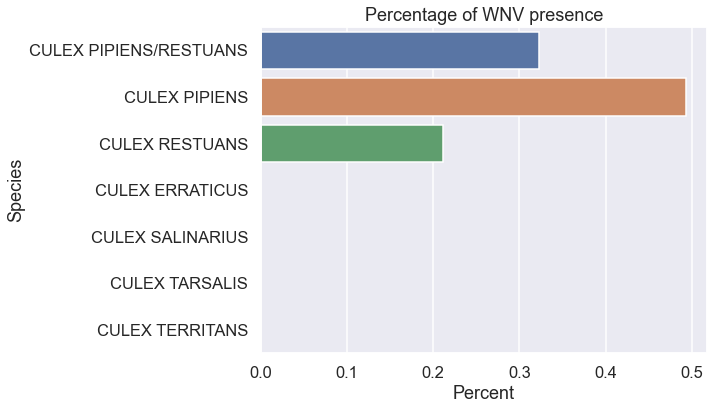

In [20]:
sns.barplot(data=species_eda, y=species_eda.index, x=species_eda['WnvPresent_Pct'], orient='h')
plt.title('Percentage of WNV presence')
plt.xlabel('Percent')

It can be observed that Culex Pipiens has the highest tendency to harbour the West Nile Virus (0.5% of the mosquito breed would typically contain the virus).

## Traps

<Figure size 1152x288 with 0 Axes>

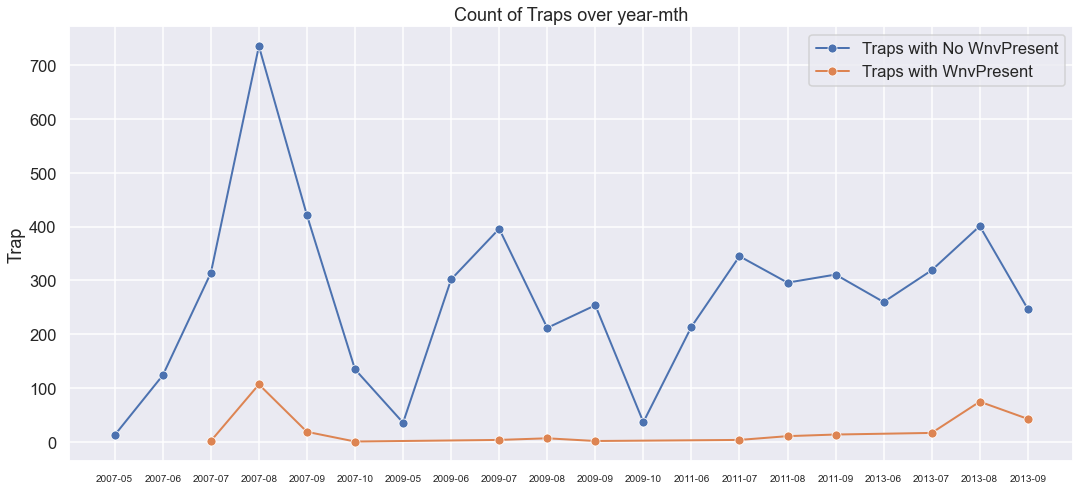

In [21]:
plt.figure(figsize=(16,4))
trap_table = pd.DataFrame(X_train.groupby(['year-mth','WnvPresent' ])['Trap'].count())
trap_table

x_index_yrmth = [keys for keys, values in trap_table.index]
hue_wnv = [values for keys, values in trap_table.index]

plt.figure(figsize=(18,8))
sns.lineplot(x = x_index_yrmth, y = 'Trap', data=trap_table.sort_index(level=0), ci=False, hue=hue_wnv, marker='o', lw=2)
plt.title('Count of Traps over year-mth')
plt.legend(['Traps with No WnvPresent', 'Traps with WnvPresent'])
plt.xticks(fontsize=10);

Above shows the time-series plot of count of `Traps` against `year-mth` from May 2007 to Sept 2013. More `Traps` were recorded from Jul 2007 to Aug 2007, this corresponds with the total `NumMosquitos` caught in the same timeline.

## Weather Features

In this part of our EDA, we will try to explore if there is any relationship between `NumMosquitos` and other weather features.

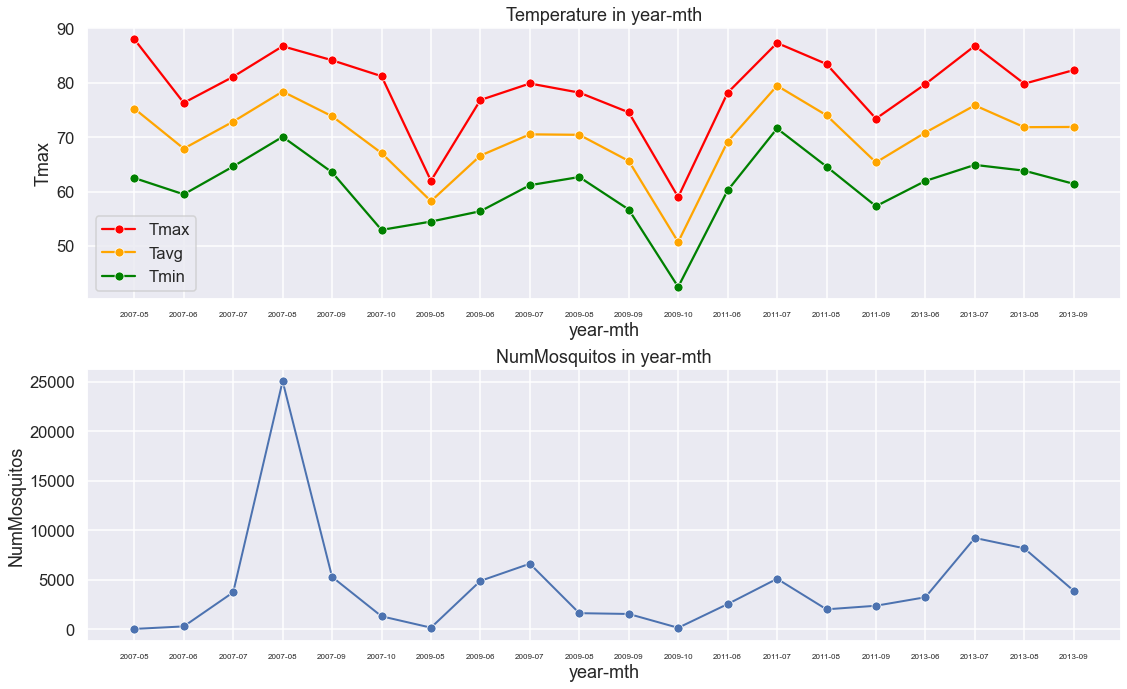

In [22]:
# temporary df groupby('year-mth')
EDA_yearmth = X_train.groupby('year-mth').mean()


#first subplot with 'Tmax', 'Tavg', 'Tmin'
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharey=False);
fig.tight_layout(pad=2.0)

sns.lineplot(ax=axes[0], x = EDA_yearmth.index , y= 'Tmax', data= EDA_yearmth, ci=False,  marker='o', color='red', label='Tmax');
sns.lineplot(ax=axes[0], x = EDA_yearmth.index , y= 'Tavg', data= EDA_yearmth, ci=False,  marker='o', color='orange', label='Tavg')
sns.lineplot(ax=axes[0], x = EDA_yearmth.index , y= 'Tmin', data= EDA_yearmth, ci=False,  marker='o', color='green', label='Tmin')
axes[0].set_title("Temperature in year-mth");
axes[0].xaxis.set_tick_params(labelsize=8)

#second subplot with 'NumMosquitos'
sns.lineplot(ax=axes[1], x = yrmth_group.index, y = "NumMosquitos", data =yrmth_group, ci=False, marker='o', lw=2)
axes[1].set_title("NumMosquitos in year-mth");
axes[1].xaxis.set_tick_params(labelsize=8)


- 1st subplot: Time-series plot of `Tmax`, `Tavg`, `Tmin` against `year-mth` from May 2007 to Sept 2013. 
- 2nd subplot: Time-series plot of `NumMosquitos` against `year-mth` from May 2007 to Sept 2013. 

We observe that there is an increase in `NumMosquitos` as `Tmax`, `Tavg`, `Tmin` increases in the same `year-mth`, temperature may help to predict presence of West Nile Virus

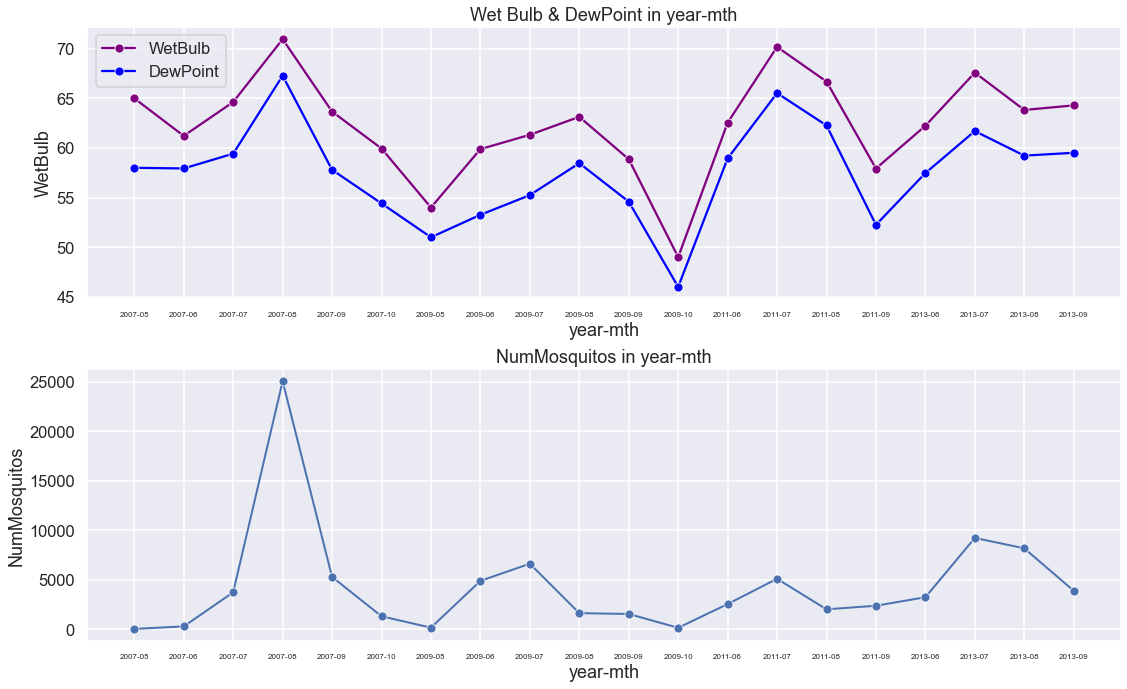

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharey=False);
fig.tight_layout(pad=2.0)

#first subplot with 'WetBulb', 'DewPoint'
sns.lineplot(ax=axes[0], x = EDA_yearmth.index , y= 'WetBulb', data= EDA_yearmth, ci=False,  marker='o', color='purple', label='WetBulb');
sns.lineplot(ax=axes[0], x = EDA_yearmth.index , y= 'DewPoint', data= EDA_yearmth, ci=False,  marker='o', color='blue', label='DewPoint')
axes[0].set_title("Wet Bulb & DewPoint in year-mth");
axes[0].xaxis.set_tick_params(labelsize=8)

#second subplot with 'NumMosquitos'
sns.lineplot(ax=axes[1], x = yrmth_group.index, y = "NumMosquitos", data =yrmth_group, ci=False, marker='o', lw=2)
axes[1].set_title("NumMosquitos in year-mth");
axes[1].xaxis.set_tick_params(labelsize=8)

- 1st subplot: Time-series plot of `WetBulb`, `DewPoint` against `year-mth` from May 2007 to Sept 2013.
- 2nd subplot: Time-series plot of `NumMosquitos` against `year-mth` from May 2007 to Sept 2013.


We observe that there is a slight increase in `NumMosquitos` as `WetBulb`, `DewPoint` increases in the same `year-mth`, however the relationship is not as strong as temperature.

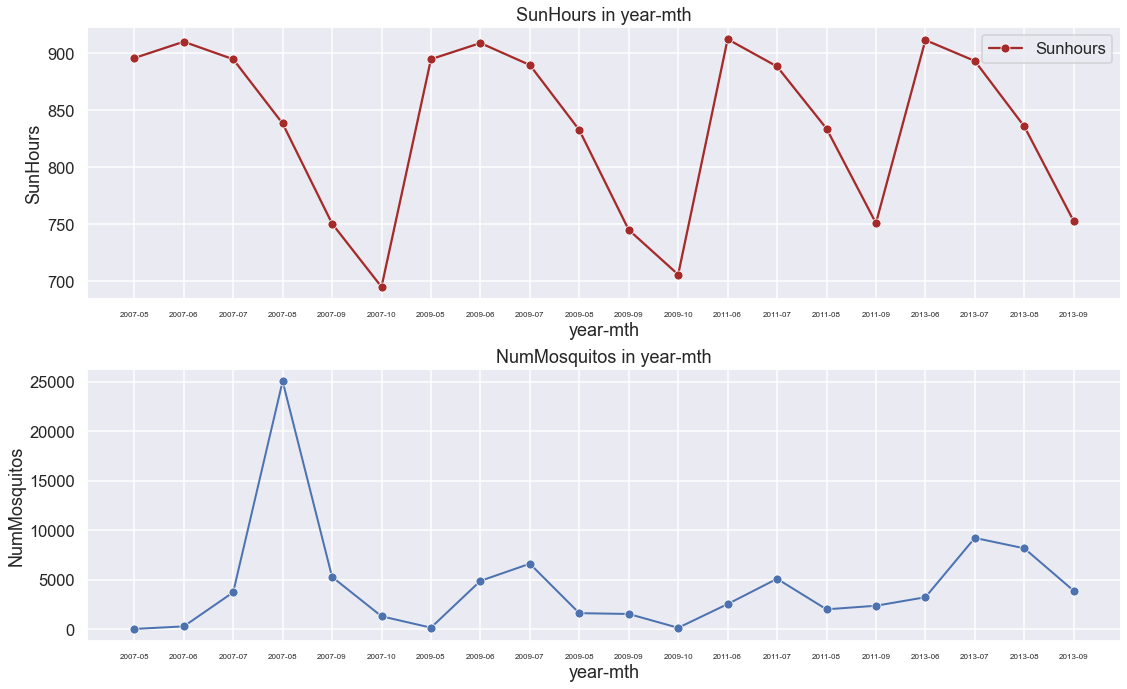

In [24]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharey=False);
fig.tight_layout(pad=2.0)

#first subplot with 'SunHours'
sns.lineplot(ax=axes[0], x = EDA_yearmth.index , y= 'SunHours', data= EDA_yearmth, ci=False,  marker='o', color='brown', label='Sunhours')
axes[0].set_title("SunHours in year-mth");
axes[0].xaxis.set_tick_params(labelsize=8)

#second subplot with 'NumMosquitos'
sns.lineplot(ax=axes[1], x = yrmth_group.index, y = "NumMosquitos", data =yrmth_group, ci=False, marker='o', lw=2)
axes[1].set_title("NumMosquitos in year-mth");
axes[1].xaxis.set_tick_params(labelsize=8)

- 1st subplot: time-series plot of `SunHours` against `year-mth` from May 2007 to Sept 2013.
- 2nd subplot: time-series plot of `NumMosquitos` against `year-mth` from May 2007 to Sept 2013.
  
We observe that there is an increase in `NumMosquitos` as `SunHours` increases in the same `year-mth`

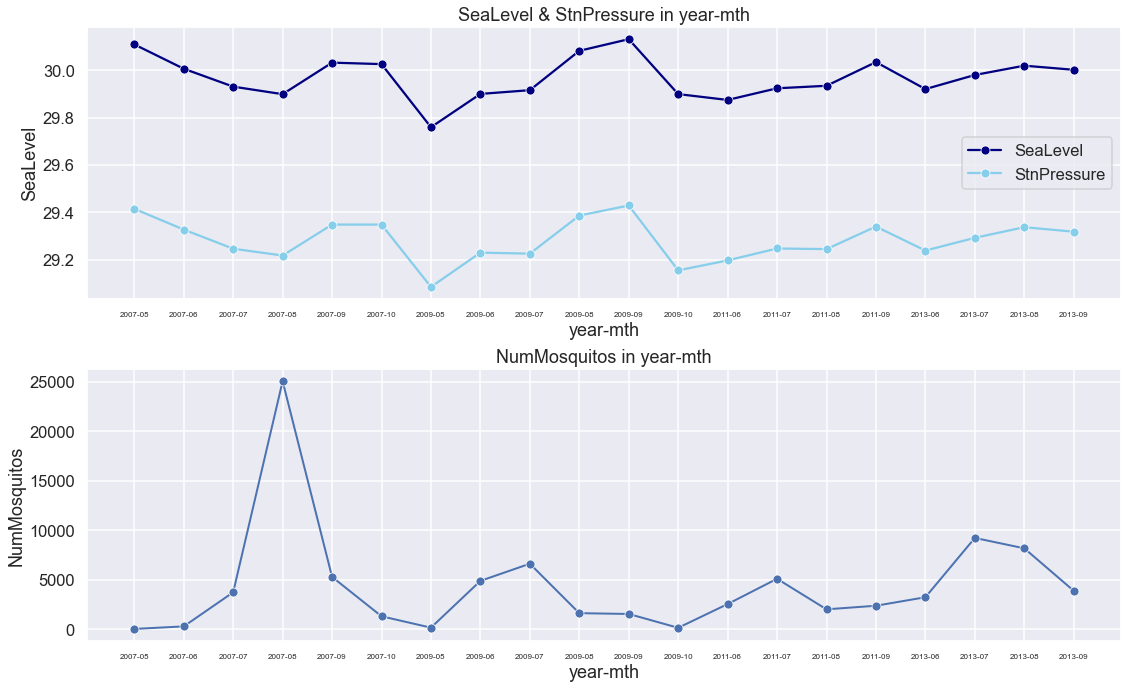

In [25]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharey=False);
fig.tight_layout(pad=2.0)

#first subplot with 'SeaLevel', 'StnPressure'
sns.lineplot(ax=axes[0], x = EDA_yearmth.index , y= 'SeaLevel', data= EDA_yearmth, ci=False,  marker='o', color='navy', label='SeaLevel')
sns.lineplot(ax=axes[0], x = EDA_yearmth.index , y= 'StnPressure', data= EDA_yearmth, ci=False,  marker='o', color='skyblue', label='StnPressure')
axes[0].set_title("SeaLevel & StnPressure in year-mth");
axes[0].xaxis.set_tick_params(labelsize=8)

#second subplot with 'NumMosquitos'
sns.lineplot(ax=axes[1], x = yrmth_group.index, y = "NumMosquitos", data =yrmth_group, ci=False, marker='o', lw=2)
axes[1].set_title("NumMosquitos in year-mth");
axes[1].xaxis.set_tick_params(labelsize=8)

- 1st subplot: time-series plot of `SeaLevel`, `StnPressure` against `year-mth` from May 2007 to Sept 2013.
- 2nd subplot: time-series plot of `NumMosquitos` against `year-mth` from May 2007 to Sept 2013.
  
We were unable to observe any relationship for  `SeaLevel`, `StnPressure`.

## Map Exploration

In this section, we will explore 2 maps: <br>1) `NumMosquitos` map & <br>
2) Spray Map


2) Spray Map will be explored in the following sequence:<br>
    - Spray map on a week basis <br>
    - (a)(i) Creating a dataframe show presence of WNV only where Spray and Train data overlap.<br>
    - (a)(ii) Plotting (a)(i) on a graph, with Week of Year on the X-axis.<br>
    - (b) Plotting the presence of <b>all</b> Spray data on a graph, with Week of Year on the X-axis.

### 1) NumMosquitos Map:
Our first map shows where the `NumMosquitos` was the highest. Darker shades of orange show a higher count of `NumMosquitos`. Blue circles indicate where the traps were situated, lime green cross marks indicate the presence of WNV.

In [26]:
X_train.columns

Index(['Date', 'Trap', 'Latitude', 'Longitude', 'Species', 'Block',
       'AddressAccuracy', 'NumMosquitos', 'WnvPresent', 'Tmax', 'Tmin', 'Tavg',
       'Depart', 'DewPoint', 'WetBulb', 'Sunrise', 'Sunset', 'CodeSum',
       'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir',
       'AvgSpeed', 'Heat/Cool', 'sunset', 'sunrise', 'SunHours', 'isRainy',
       'Humidity', 'year-mth', 'Year', 'Month', 'Week'],
      dtype='object')

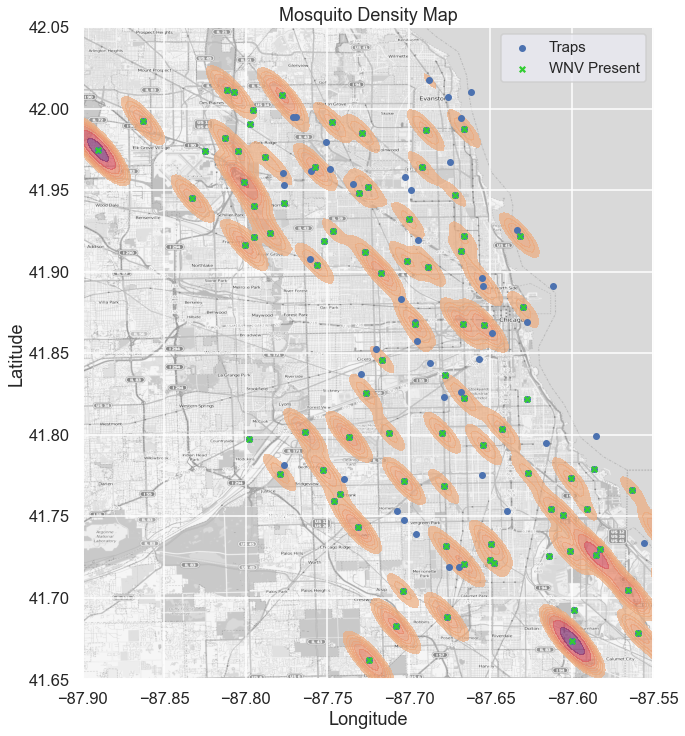

In [27]:
origin = [41.65, -87.90] 
upperRight = [42.05, -87.55]

mapdata = np.loadtxt("../assets/mapdata_copyright_openstreetmap_contributors.txt")

numPoints = 50
long_nooutlier = spray[spray['Longitude'] > -88]
lats = long_nooutlier['Latitude']
longs = long_nooutlier['Longitude']

intersection = [41.909614, -87.746134]  # co-ordinates of intersection of IL64 / IL50 according to Google Earth

plt.figure(figsize=(12,12));
plt.imshow(mapdata, cmap=plt.get_cmap('Greys_r'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])
# ax = sns.kdeplot(x=longs, y=lats, cmap="GnBu", shade=True, bw_adjust=.5, thresh=0, alpha=0.7, legend=True)
# ax.collections[0].set_alpha(0)

num_mozzies = X_train[X_train['NumMosquitos'] > 0][['NumMosquitos','Longitude', 'Latitude']]
# Create empty dataframe to populate as density map
mozzie_density = num_mozzies.drop(num_mozzies.index)
# For each point - add NumMosquito rows of the point for KDE plot
for i, row in num_mozzies.iterrows():
    mozzie_density=mozzie_density.append([row] * int(row['NumMosquitos']))
lats = mozzie_density['Latitude']
longs = mozzie_density['Longitude']
ax = sns.kdeplot(x=longs, y=lats, cmap="flare", shade=True, bw_adjust=.4, thresh=0, alpha=0.7, legend=True)
ax.collections[0].set_alpha(0)

traps = X_train[['Longitude', 'Latitude']].drop_duplicates()
# traps = traps[(-87.9 < traps['Longitude']) & ( traps['Longitude'] < -87.55) & (traps['Latitude'] > 41.65)]
lats = traps['Latitude']
longs = traps['Longitude']
plt.scatter(x=longs, y=lats, c='b', s=30, label='Traps');

wnv_present = X_train[X_train['WnvPresent'] == 1][['Longitude', 'Latitude']].drop_duplicates()
# wnv_present = present[(-87.9 < present['Longitude']) & ( present['Longitude'] < -87.55)]
lats = wnv_present['Latitude']
longs = wnv_present['Longitude']
plt.scatter(x=longs, y=lats, c='limegreen', s=30 ,marker='x', label='WNV Present');

plt.legend(fontsize=15);

plt.xlim(-87.9,-87.55)
plt.ylim(41.65,42.05)
plt.title("Mosquito Density Map")
plt.savefig('mosquito_density.png', transparent=True)

The above map shows us an overall visual of areas that had dense mosquito populations.

However, this is for our entire X_train dataset which covers data for every alternate year from 2007 to 2013.

Points where WNV was present (marked in green crosses) generally were also areas that had high populations of mosquitoes (shaded in peach).

We can also see in below correlations plot that NumMosquitos indeed has a positive relationship with the presence of WNV. Many of the WNVPresent points (marked in green) overlap with the blue circles (Mosquito traps) or are close in proximity.

While WNV was present in areas with a lot of mosquitos, we can see from the above map that WNV can be present in areas of lower Mosquito Populations as well - but this is a less frequent observation.

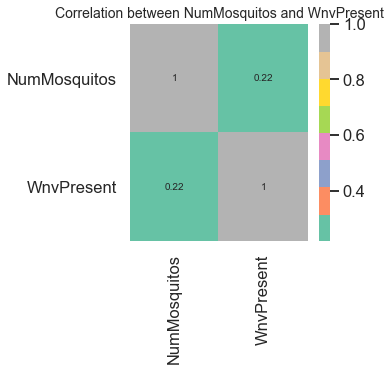

In [28]:
plt.figure(figsize = (4,4))
sns.heatmap(X_train[['NumMosquitos','WnvPresent']].corr(), 
            cmap="Set2", 
            annot=True, 
            annot_kws={'size':10});
plt.title("Correlation between NumMosquitos and WnvPresent", size=14);
plt.savefig('mozzie_wnv.png', transparent=True, bbox_inches='tight')

### 2) Spray Map:

Our Second map shows the location of sprays by week. Black circles show us where the traps were located, and pink crosses represent where there were outbreaks of the West Nile Virus. Areas shaded in turqouise represent the concentration of spray - with darker showing a higher concentration.

We would like to first get an overview of where the sprays were released in relation to the presence of WNV.

In [29]:
#overview of spray data
spray

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858
...,...,...,...,...
14289,2013-09-05,8:34:11 PM,42.006587,-87.812355
14290,2013-09-05,8:35:01 PM,42.006192,-87.816015
14291,2013-09-05,8:35:21 PM,42.006022,-87.817392
14292,2013-09-05,8:35:31 PM,42.005453,-87.817423


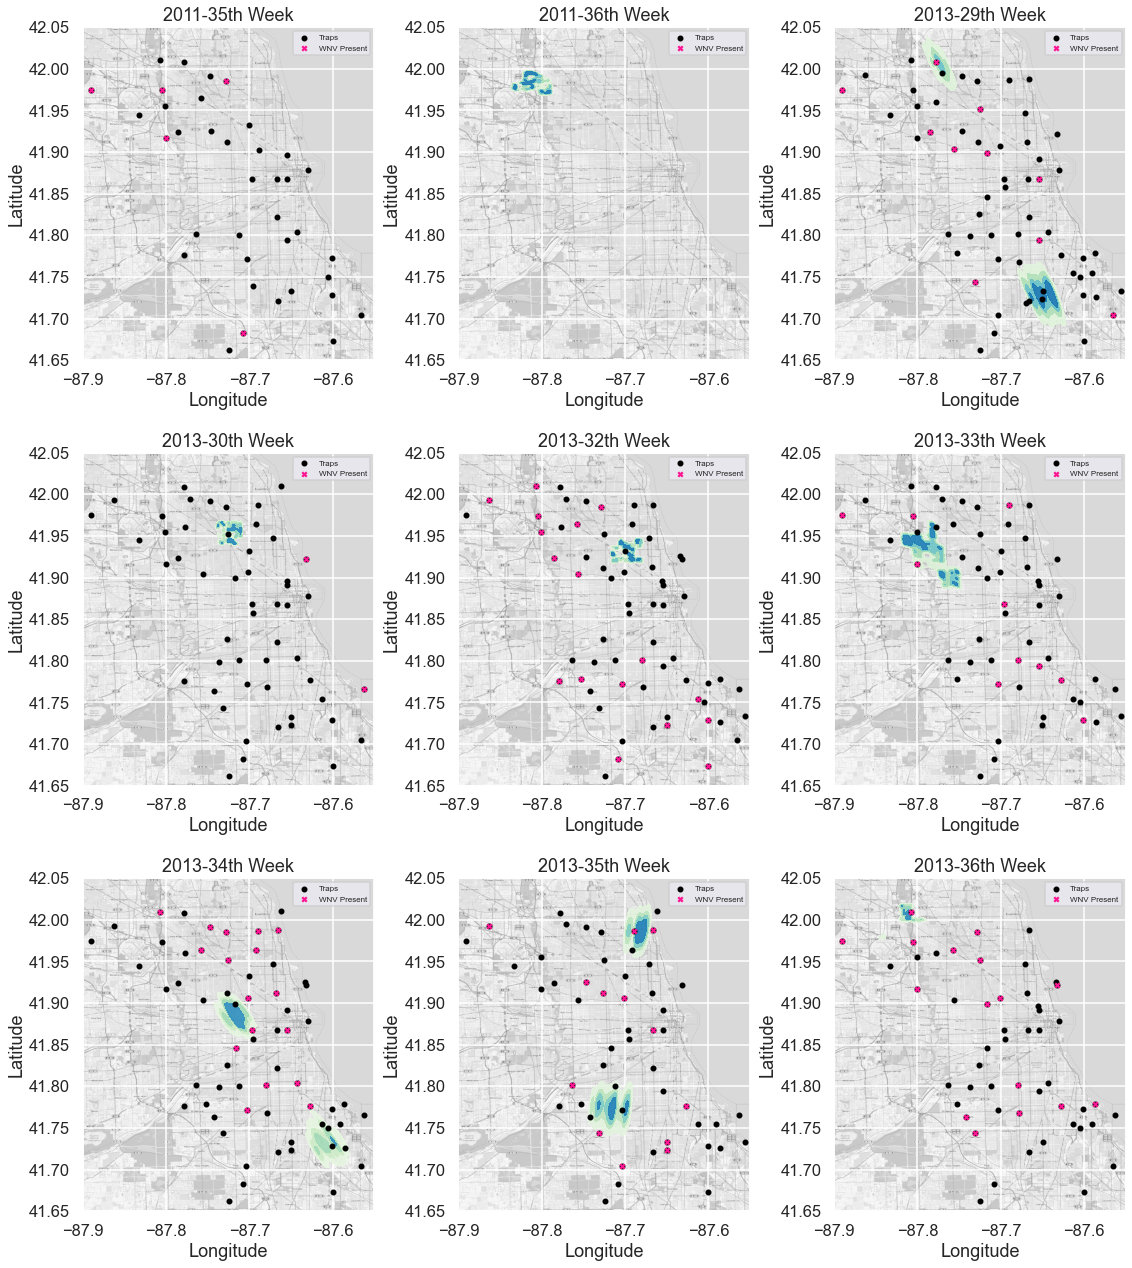

In [30]:
#making a copy of original spray data
spray_copy = spray.copy()

#creating Date/Year/Month/year-mth formats in spray_copy
spray_copy['Date'] = pd.to_datetime(spray_copy['Date'])
spray_copy['year-week'] = pd.to_datetime(spray_copy['Date']).apply(lambda x: '{}-{:02d}'.format(x.year, x.week))
spray_copy['year'] = spray_copy.Date.dt.year

#making a copy of X_train data
train_copy = X_train.copy()
train_copy['year-week'] = pd.to_datetime(train_copy['Date']).apply(lambda x: '{}-{:02d}'.format(x.year, x.week))

#setting map boundaries
origin = [41.65, -87.90] 
upperRight = [42.05, -87.55]
mapdata = np.loadtxt("../assets/mapdata_copyright_openstreetmap_contributors.txt")

nrows = int(np.ceil(len(spray_copy['year-week'].unique())/3)) 
fig, ax = plt.subplots(nrows=nrows, ncols = 3,figsize=(16,18))
ax=ax.ravel()
#plotting points from our train set where traps are situated & removing duplicate traps
traps = train_copy[['year-week','Longitude', 'Latitude']].drop_duplicates()
#plotting points on our train set where WNV is present & removing duplicates
present = train_copy[train_copy['WnvPresent'] == 1][['year-week','Longitude', 'Latitude']].drop_duplicates()

for i,year_week in enumerate(spray_copy['year-week'].unique()):
    #using kdeplot to plot density of spray given mapdata
    ax[i].imshow(mapdata, 
                 cmap=plt.get_cmap('Greys_r'),
                 extent=[origin[1], 
                     upperRight[1],
                     origin[0], 
                     upperRight[0]])
    #getting the sprays that were made on that year/week
    filtered_spray = spray_copy[(spray_copy['year-week']==year_week)]
    lats = filtered_spray['Latitude']
    longs = filtered_spray['Longitude']
    axs = sns.kdeplot(x=longs, 
                        y=lats, 
                        cmap="GnBu", 
                        shade=True, 
                        bw_adjust=.5, 
                        thresh=0.1, 
                        alpha=0.9, 
                        legend=True,
                        ax=ax[i],
                        levels=5)
    
    #filtering for traps on that year in that week
    filtered_traps = traps[(traps['year-week']==year_week)]
    lats = filtered_traps['Latitude']
    longs = filtered_traps['Longitude']
    ax[i].scatter(x=longs, y=lats, c='black', marker='o', s=20, label='Traps');
    
    #getting the WNV presence for that year/week
    filtered_present = present[(present['year-week']==year_week)]
    lats = filtered_present['Latitude']
    longs = filtered_present['Longitude']
    ax[i].scatter(x=longs, y=lats, c='deeppink', s=20 ,marker='x', label='WNV Present');

    ax[i].legend(fontsize=8)
    ax[i].set_title(f'{year_week}th Week')
    ax[i].set_xlim(-87.9,-87.55)
    ax[i].set_ylim(41.65,42.05)
    plt.savefig(f'{year_week}th_week_sprayplot.png', transparent=True)
plt.tight_layout()

The above map shows us an overall visual view of what our spray data tells us across weeks that were sprayed.

We can observe the following based on the spray map (there is no trap data in our train set for the 36th week of 2011, despite having this data in our spray set - trap data was possibly left unrecorded).

1) We would like to observe the week on week effect here. In 2011, sprays in the 35th week were not made within range (this will be explained in the below section) and therefore does not show up in our spray plots. Due to the lack of trap data for 2011 Week 36, we are unable to make concrete observations based on our 2011 spray data.

2) In 2013, we see that areas with pink markers (WNV present) that overlapped the spray markers mostly disappeared in the following week's spray. Sprays seemed somewhat effective in removing WNV. However, an important thing to note here is that these sprays do not seem to be well targeted - there were areas that WNV was more prominent, but these areas were not sprayed. Generally speaking, areas that should have been sprayed were not identified well.

We shall go deeper into the analysis of the sprays below.

### 2(a)(i) Creating a DataFrame to show the Presence of WNV across areas where Spray and Train data:
According to our research, spray travels only about 90metres (300FT), so we only want to look at values of closest spray less than our threshold of 120m. Other areas in the train dataset that are out of this range will not have been influenced by mosquito spray.

In the map above, if the sprays were effective we would see a reduced amount of outbreaks in areas that are close to the spraying locations.

We will compare our spray data with existing train data to go further into our explorations. The spray data that we will use only starts in the year 2011.

Making a copy of spray data to compare against train data:

In [31]:
spray_sub = spray.copy()
spray_sub['Date'] = [pd.to_datetime(date) for date in spray_sub['Date']] #converting Date to the correct format
spray_sub.drop(columns='Time', inplace=True) #dropping unnecessary column
spray_sub

,Date,Latitude,Longitude
0,2011-08-29,42.391623,-88.089163
1,2011-08-29,42.391348,-88.089163
2,2011-08-29,42.391022,-88.089157
3,2011-08-29,42.390637,-88.089158
4,2011-08-29,42.390410,-88.088858
...,...,...,...
14289,2013-09-05,42.006587,-87.812355
14290,2013-09-05,42.006192,-87.816015
14291,2013-09-05,42.006022,-87.817392
14292,2013-09-05,42.005453,-87.817423


Check data types

In [32]:
spray_sub.dtypes

Date         datetime64[ns]
Latitude            float64
Longitude           float64
dtype: object

Rename columns so we know which one belong to spray

In [33]:
spray_sub.rename(columns={'Latitude':'latitude_sp',
                          'Longitude':'longitude_sp'
                         }, inplace=True)
spray_sub

,Date,latitude_sp,longitude_sp
0,2011-08-29,42.391623,-88.089163
1,2011-08-29,42.391348,-88.089163
2,2011-08-29,42.391022,-88.089157
3,2011-08-29,42.390637,-88.089158
4,2011-08-29,42.390410,-88.088858
...,...,...,...
14289,2013-09-05,42.006587,-87.812355
14290,2013-09-05,42.006192,-87.816015
14291,2013-09-05,42.006022,-87.817392
14292,2013-09-05,42.005453,-87.817423


Make a copy of train to compare against spray data

In [34]:
train_sub = X_train.copy()
train_sub.columns

Index(['Date', 'Trap', 'Latitude', 'Longitude', 'Species', 'Block',
       'AddressAccuracy', 'NumMosquitos', 'WnvPresent', 'Tmax', 'Tmin', 'Tavg',
       'Depart', 'DewPoint', 'WetBulb', 'Sunrise', 'Sunset', 'CodeSum',
       'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir',
       'AvgSpeed', 'Heat/Cool', 'sunset', 'sunrise', 'SunHours', 'isRainy',
       'Humidity', 'year-mth', 'Year', 'Month', 'Week'],
      dtype='object')

Drop unnecessary columns

In [35]:
train_sub = train_sub.drop(['AddressAccuracy', 'Tmax', 'Tmin', 'Tavg', 'Depart',
       'DewPoint', 'WetBulb', 'Sunrise', 'Sunset', 'CodeSum', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed',
       'Heat/Cool', 'sunset', 'sunrise', 'SunHours', 'isRainy',
       'Humidity', 'year-mth'], axis=1)
train_sub

,Date,Trap,Latitude,Longitude,Species,Block,NumMosquitos,WnvPresent,Year,Month,Week
8074,2013-09-06,T048,41.867108,-87.654224,CULEX PIPIENS,11,12,0,2013,9,36
5548,2011-08-05,T030,41.899230,-87.716788,CULEX RESTUANS,10,3,0,2011,8,31
4685,2009-10-01,T900,41.974689,-87.890615,CULEX PIPIENS,10,3,0,2009,10,40
5576,2011-08-05,T080,41.754676,-87.612922,CULEX PIPIENS/RESTUANS,77,7,0,2011,8,31
323,2007-07-11,T048,41.867108,-87.654224,CULEX PIPIENS/RESTUANS,11,3,0,2007,7,28
...,...,...,...,...,...,...,...,...,...,...,...
7607,2013-08-08,T212,41.680946,-87.535198,CULEX RESTUANS,37,4,0,2013,8,32
4235,2009-08-27,T220,41.963976,-87.691810,CULEX PIPIENS/RESTUANS,45,2,0,2009,8,35
2855,2009-06-02,T046,41.891118,-87.654491,CULEX PIPIENS/RESTUANS,25,1,0,2009,6,23
5920,2011-08-26,T089,41.723195,-87.649970,CULEX PIPIENS/RESTUANS,10,1,0,2011,8,34


Renaming columns to identify which are from train set:

In [36]:
train_sub.rename(columns = {'Latitude':'latitude_tr',
                            'Longitude':'longitude_tr',
                            'Trap':'trap_tr',
                            'NumMosquitos':'num_mosquitos_tr',
                            'WnvPresent':'wnv_present_tr'
                           }, inplace=True)

train_sub
train_sub['Date'] = [pd.to_datetime(date) for date in train_sub['Date']]

In [37]:
train_sub.columns

Index(['Date', 'trap_tr', 'latitude_tr', 'longitude_tr', 'Species', 'Block',
       'num_mosquitos_tr', 'wnv_present_tr', 'Year', 'Month', 'Week'],
      dtype='object')

Create a function to map the closest point of spray to train data

In [38]:
def closest_point(point, points):
    if len(points) <= 0 or point == None:
        return None
    #finding closest point from a list of points
    return points[cdist([point], points).argmin()]

# group lat and long values into points
spray_sub['point'] = list(zip(spray_sub['latitude_sp'], spray_sub['longitude_sp']))
train_sub['point'] = list(zip(train_sub['latitude_tr'], train_sub['longitude_tr']))

# getting the closest spray point (on the same date as train row)
train_sub['closest_spray'] = train_sub.apply(lambda row: closest_point(row['point'], list(spray_sub.loc[spray_sub['Date'] == row['Date']]['point'])), axis=1)

# saving the distance between the closest spray and the train point
train_sub['closest_distance'] = train_sub.apply(lambda row: geodesic(row['point'], row['closest_spray']).m , axis=1)
train_sub['closest_distance'] = train_sub['closest_distance'].astype(float)

train_sub['closest_distance']

8074    9.816567e+06
5548    9.821845e+06
4685    9.836450e+06
5576    9.812825e+06
323     9.816567e+06
            ...     
7607    2.894496e+04
4235    9.819948e+06
2855    9.816655e+06
5920    9.815819e+06
6052    9.808753e+06
Name: closest_distance, Length: 5678, dtype: float64

Creating a combined df of train and spray called train_spray:

In [39]:
train_spray = train_sub.copy()
print(train_spray['closest_distance'].isnull().sum())
train_spray.head()

0


,Date,trap_tr,latitude_tr,longitude_tr,Species,Block,num_mosquitos_tr,wnv_present_tr,Year,Month,Week,point,closest_spray,closest_distance
8074,2013-09-06,T048,41.867108,-87.654224,CULEX PIPIENS,11,12,0,2013,9,36,"(41.867108, -87.654224)",None,9.816567e+06
5548,2011-08-05,T030,41.899230,-87.716788,CULEX RESTUANS,10,3,0,2011,8,31,"(41.89923, -87.716788)",None,9.821845e+06
4685,2009-10-01,T900,41.974689,-87.890615,CULEX PIPIENS,10,3,0,2009,10,40,"(41.974689, -87.890615)",None,9.836450e+06
5576,2011-08-05,T080,41.754676,-87.612922,CULEX PIPIENS/RESTUANS,77,7,0,2011,8,31,"(41.754676, -87.612922)",None,9.812825e+06
323,2007-07-11,T048,41.867108,-87.654224,CULEX PIPIENS/RESTUANS,11,3,0,2007,7,28,"(41.867108, -87.654224)",None,9.816567e+06


Checking data types:

In [40]:
train_spray.dtypes

Date                datetime64[ns]
trap_tr                     object
latitude_tr                float64
longitude_tr               float64
Species                     object
Block                        int64
num_mosquitos_tr             int64
wnv_present_tr               int64
Year                         int64
Month                        int64
Week                         int64
point                       object
closest_spray               object
closest_distance           float64
dtype: object

Find all the rows where closest spray/distance are .notnull and sorts values by column

In [41]:
train_spray[train_spray[
    ['closest_spray',
     'closest_distance']].notnull().all(axis=1)].sort_values(by='closest_distance')

#filtering for those with closest distance <120 & >0
train_spray = train_spray[(train_spray['closest_distance'] < 120) & (train_spray['closest_distance'] >= 0)]
train_spray.set_index('Date', inplace=True)

#sorting by ascending distance and showing coordinates of the closest spray, as well as distance of closest spray
train_spray.sort_values(by = 'closest_distance',ascending=True)[['closest_spray','closest_distance']]

,closest_spray,closest_distance
Date,,
2013-07-25,"(41.9518783333333, -87.72502166666668)",3.234061
2013-08-08,"(41.9316183333333, -87.700245)",53.889275
2013-08-15,"(41.9167783333333, -87.8005316666667)",57.033549
2013-08-15,"(41.9167783333333, -87.8005316666667)",57.033549
2013-08-29,"(41.9867, -87.6907916666667)",87.513591
2013-08-22,"(41.7294333333333, -87.6009816666667)",104.230400
2013-08-22,"(41.7294333333333, -87.6009816666667)",104.230400
2013-08-29,"(41.98824000000001, -87.6658433333333)",108.214816
2013-08-29,"(41.98824000000001, -87.6658433333333)",108.214816


The above dataframe shows us a list of locations with nearby sprays since we wanted to take into account the distance travelled by spray. We will check the overlapped sprayed areas using a line plot.

Generally, our spray data shows that sprays did not prove to be very effective in predicting or reducing the occurrences of WNV. Moreover, we had a limited amount of spray data - only 2 data points of spraying for 2011, with more in 2013. 

### 2(a)(ii) Plotting instances of sprays where Sprays and Train overlaps

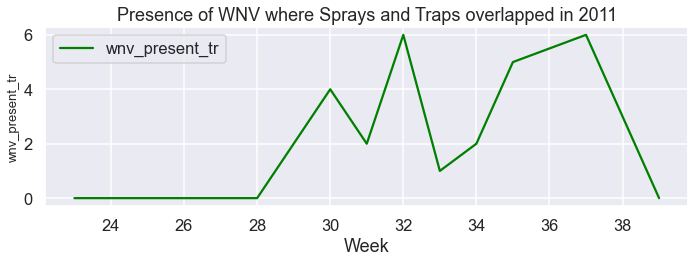

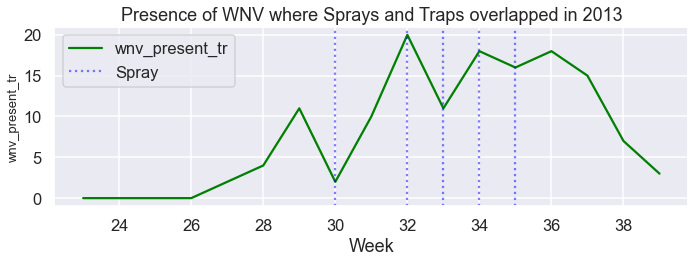

In [42]:
spray_year = [2011, 2013]

for year in spray_year:
    target = 'wnv_present_tr'
    color='red'
    # train_spray['year'] = train_spray.apply(lambda row: row.index.year, axis=1)

    fig, ax1 = plt.subplots(figsize=(10,4))
    temp_df = train_sub[train_sub['Year']==year].groupby(['Week'])[target].sum().to_frame()

    sns.lineplot(x=temp_df.index, y=temp_df[target],
                         ci=None, color='green', label=f'{target}', ax=ax1)
    ax1.set_ylabel(f'{target}', fontsize=13)
    ax1.legend(loc=1)

    for date in train_spray[train_spray['Year'] == year].groupby('Week').mean().index:
        plt.axvline(date, linestyle=':', color='blue', alpha=0.5, label='Spray')

    plt.legend([f'{target}', 'Spray'])
    plt.title(f'Presence of WNV where Sprays and Traps overlapped in {year}')
    plt.tight_layout()
    plt.savefig(f'Presence of WNV where Sprays and Traps overlapped {year}.png', transparent=True)

In [43]:
train_spray.head()

,trap_tr,latitude_tr,longitude_tr,Species,Block,num_mosquitos_tr,wnv_present_tr,Year,Month,Week,point,closest_spray,closest_distance
Date,,,,,,,,,,,,,
2013-08-29,T066,41.771660,-87.703047,CULEX PIPIENS/RESTUANS,134,51,0,2013,8,35,"(41.77166, -87.703047)","(41.772181666666704, -87.701815)",117.687076
2013-08-29,T231,41.987280,-87.666066,CULEX RESTUANS,58,11,0,2013,8,35,"(41.98728, -87.666066)","(41.98824000000001, -87.6658433333333)",108.214816
2013-08-29,T231,41.987280,-87.666066,CULEX PIPIENS/RESTUANS,58,39,1,2013,8,35,"(41.98728, -87.666066)","(41.98824000000001, -87.6658433333333)",108.214816
2013-08-15,T151,41.916265,-87.800515,CULEX PIPIENS/RESTUANS,70,11,0,2013,8,33,"(41.916265, -87.800515)","(41.9167783333333, -87.8005316666667)",57.033549
2013-08-22,T227,41.728495,-87.600963,CULEX RESTUANS,65,16,0,2013,8,34,"(41.728495, -87.60096300000002)","(41.7294333333333, -87.6009816666667)",104.230400


We used the train_spray dataframe to plot the above 2 charts. The dotted lines represent the weeks of spray while the solid line represents the presence of WNV. To revisit this, train_spray was a dataframe narrowed down to where can see from above that weeks that had sprays showed no consistent trend to suggest that spraying had an effect on the presence of WNV. Of 2 sprays total in 2011, and 7 sprays total in 2013, only 5 sprays in 2013 were made in areas with traps.

In 2011, despite that sprays were made, none were made close enough to traps (within our benchmark range of 120m) and thus we were unable to see the relationship with the presence of WNV. 

Generally, areas where sprays were made seem to have not been best placed, and could be better located. There was no clear relationship of the impact spray had on WNV with our existing data.

### 2b) Presence of WNV across <b>all</b> weeks of sprays

This is an overview of <b>all</b> instances of sprays made, and not just those that were identified in areas with traps.

<ipython-input-44-b03f817d5d62>:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  spray_copy['Week'] = spray_copy['Date'].dt.week


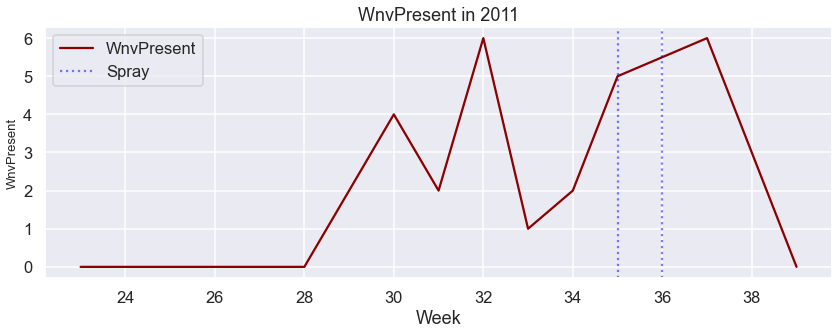

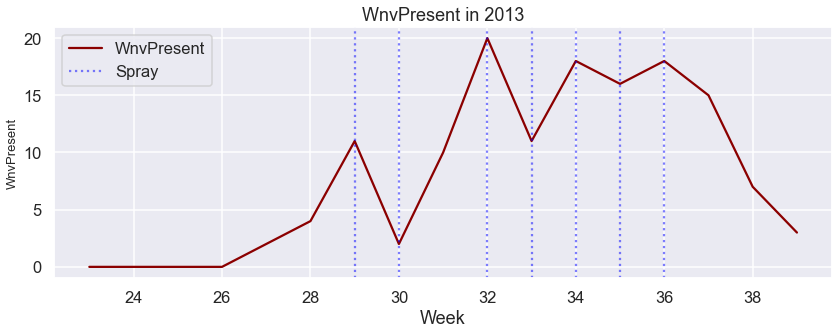

In [44]:
spray_year = [2011, 2013]

spray_copy = spray.copy()

spray_copy['Date'] = pd.to_datetime(spray_copy['Date'])
spray_copy['Year'] = spray_copy['Date'].dt.year
spray_copy['Week'] = spray_copy['Date'].dt.week

for year in spray_year:
    target = 'WnvPresent'
    color='darkred'
    
    fig, ax1 = plt.subplots(figsize=(12,5))
    weekly_sum = X_train[X_train['Year']==year].groupby(['Week'])[target].sum()
 
    sns.lineplot(x=weekly_sum.index, y=list(weekly_sum),
                         ci=None, color=color, label=f'{target}', ax=ax1)
    ax1.set_ylabel(f'{target}', fontsize=13)
    ax1.legend(loc=1)

    for week in (spray_copy[spray_copy['Year'] == year]['Week'].unique()):
        plt.axvline(week, linestyle=':', color='blue', alpha=0.5, label='Spray')
    plt.legend([f'{target}', 'Spray'])
    plt.title(f'{target} in {year}')
    plt.tight_layout()
    plt.savefig(f'{target, year}.png', transparent=True)


Based on the spray data, it seems that sprays were only made towards the end of the peak presence of WNV - which is in weeks 35 and 36 of 2011 (end of August). In 2013, our spraying data starts earlier at week 29 (end of June), but there is only a weak pattern in reducing the presence of WNV with the use of sprays due to the lack of data.

In our earlier part of the EDA, we have established that mosquito counts peak in July/August. Since spraying is primarily targeted at adult mosquitoes ([Source](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1365-2915.2011.00992.x)), perhaps it would be better for sprays to take place pre-peak season to prevent adult mosquitoes from breeding further instead of focusing on eradicating the existing adult population. 

In conclusion, more preventative spraying techniques could be employed rather than mitigative.  Moreover due to large gaps and irregularity in our spray data, the spray data fails to be useful in predicting the presence of WNV. A more consistent set of spray data would be required for us to use this data.

# Correlations

Here we check for correlations of most numeric features on `WnvPresent`. This is just an overview - we will delve deeper into lagged and rolled features.

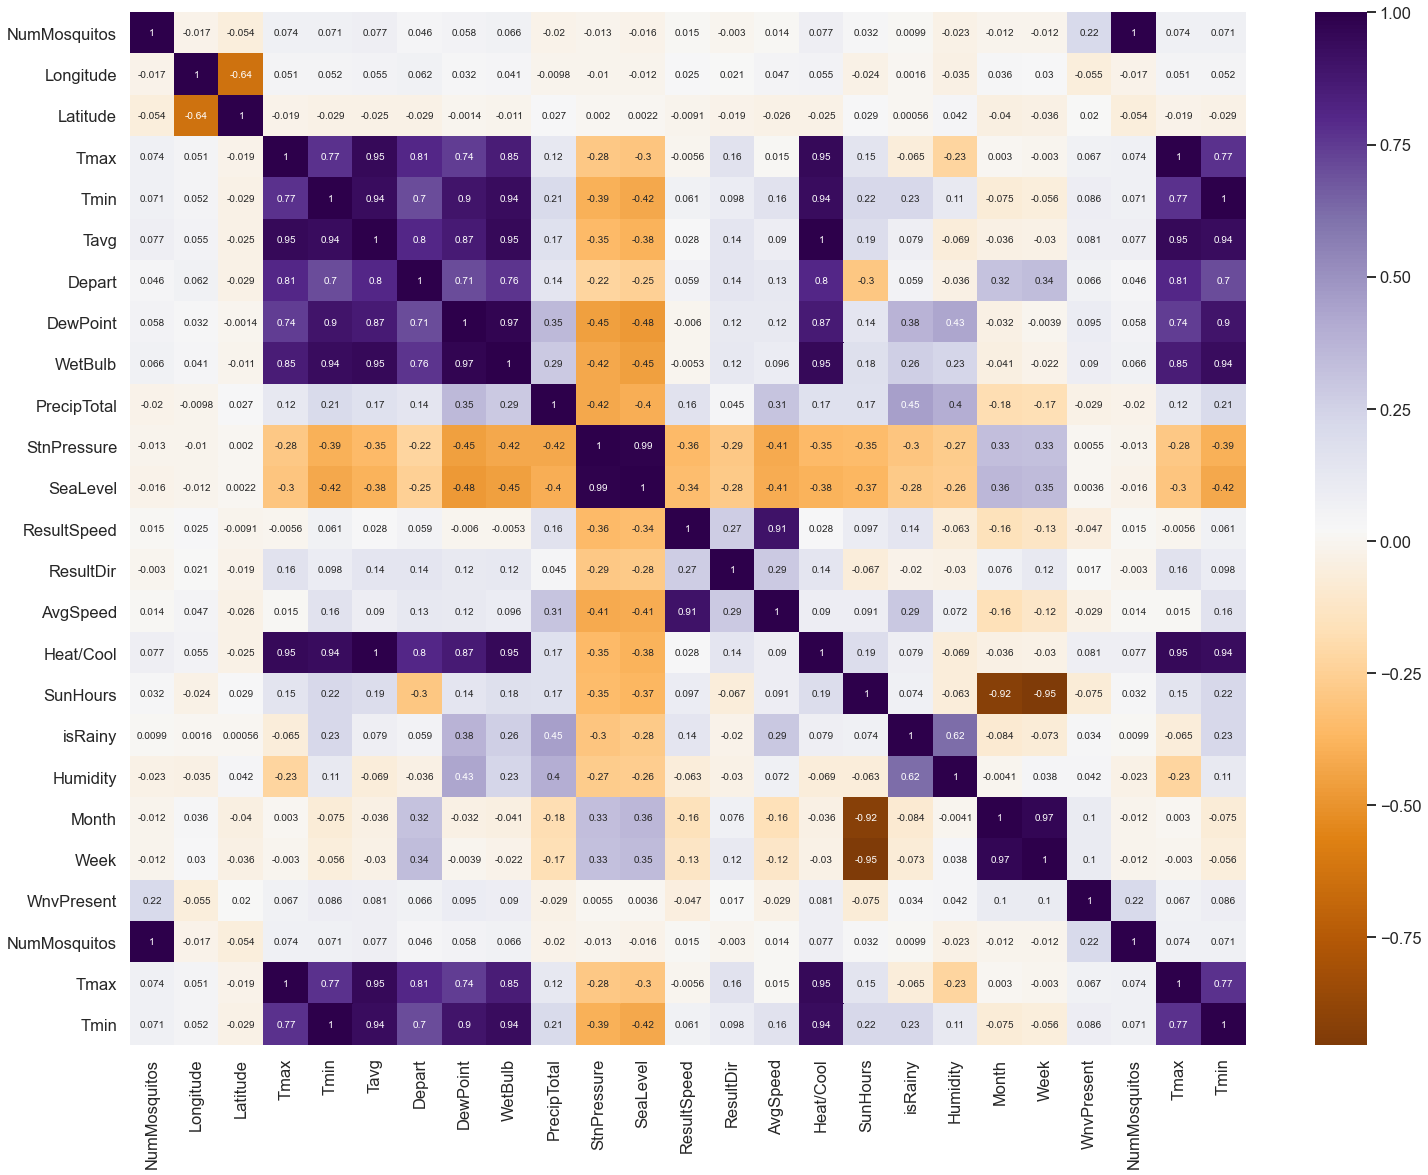

In [45]:
X_train_corr = X_train[['NumMosquitos', 'Longitude', 'Latitude',
                        'Tmax', 'Tmin', 'Tavg', 'Depart',
                        'DewPoint', 'WetBulb', 'PrecipTotal',
                        'StnPressure', 'SeaLevel', 'ResultSpeed', 
                        'ResultDir', 'AvgSpeed',
                        'Heat/Cool', 'SunHours', 'isRainy',
                        'Humidity','Month', 'Week', 'WnvPresent', 
                        'NumMosquitos', 'sunset', 'sunrise', 
                        'year-mth', 'Tmax','Tmin'
                       ]].corr()

plt.figure(figsize = (25,19))
sns.heatmap(X_train_corr, cmap=plt.cm.PuOr, annot=True, annot_kws={'size':10},
);

We want to explore features when they are lagged and rolled against their base values versus the correlation against `WnvPresent`, this could give us stronger features to work with in our model.

In [46]:
def cross_corr(feature):
    """
    Takes a given weather feature and creates a cross correlation matrix of WNVPresent
    and that feature rolled and lagged to various degrees. 
    Each feature is lagged i days, and rolled j days where i+j <= 28. This is because 28 days is the maximum buffer 
    we have for weather data before the first trap gets sampled.
    E.g. A feature lagged by 10 days will be rolled 1-17 more days.
    Every such combination of roll and lag within 28 days will be correlated against WnvPresent, 
    and plotted onto a heatmap. The combination that produces the highest absolute correlation will have its
    correlation coefficient annotated on the heatmap.
    """
    tmp = X_train[['WnvPresent', feature, 'Date']].copy()
    tmp['Date'] = tmp['Date'].astype(str)
    coef_list = []
    for i in range(1,28):    # lag feature by i days
        row = []
        for j in range(1, (29-i)):    # roll feature by j days
            label = feature + '_lag' + str(i) + '_r' + str(j)
            # create the lagged and rolled feature
            weather[label] = weather[feature].shift(i).rolling(j).mean()
            # merge it with the main table
            tmp = tmp.merge(weather[[label, 'Date']], on='Date')
            # calculate correlation for WNV and new feature
            coef = np.corrcoef([tmp['WnvPresent'], tmp[label]])[0,1]
            # store correlation coefs for i-th lag with j-th roll in a list
            row.append(coef)
        row = np.array(row)
        row.resize(27)
        # store all coefficients from each lagged day into a bigger list
        coef_list.append(row)
    # create correlation table
    corr_map = pd.DataFrame(coef_list, 
                            columns=['roll_'+ str(i) for i in range(1,28)], 
                            index=['lag_'+ str(i) for i in range(1,28)])
    # inverting it to make heatmap easier to read
    corr_map = corr_map.iloc[::-1]
    # extract the largest absolute correlation found to annotate in heatmap later
    maximum = abs(corr_map.values).max()
    labels = corr_map.applymap(lambda x: str(round(x,3)) if abs(x) == maximum else '')
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(corr_map, annot=labels, annot_kws = {'fontsize':8}, 
                fmt='', square=True, cbar_kws={"shrink": .70}, cmap=plt.cm.PuOr),
    ax.tick_params(labelsize=8)
    ax.set_title('Cross correlation map for {} with WNVPresent'.format(feature))

In [47]:
cols_to_corr = [
                'Tavg',
                'Humidity',
                'AvgSpeed',
                'DewPoint',
                'WetBulb',
                ]

In [ ]:
for col in cols_to_corr:
    cross_corr(col)

From above cross-correlation maps, we identified that some features showed stronger correlation against `WnvPresent` when they are rolled and lagged. We feature these into our dataset.

In [ ]:
weather['DewPoint_Roll22Lag1'] = weather['DewPoint'].shift(1).rolling(22).mean()
weather['WetBulb_Roll16Lag7'] = weather['WetBulb'].shift(7).rolling(16).mean()
weather['AvgSpeed_Roll22Lag5'] = weather['AvgSpeed'].shift(5).rolling(22).mean()
weather['Humidity_Roll16Lag1'] = weather['Humidity'].shift(1).rolling(16).mean()
weather['isRainy_Roll6Lag21'] = weather['isRainy'].shift(21).rolling(6).mean()
weather['PrecipTotal_Roll1Lag5'] = weather['PrecipTotal'].shift(5).rolling(1).mean()
weather['ResultSpeed_Roll23Lag5'] = weather['ResultSpeed'].shift(5).rolling(23).mean()
weather['Heat/Cool_Roll12Lag12'] = weather['Heat/Cool'].shift(12).rolling(12).mean()
weather['Tavg_Roll12Lag12'] = weather['Tavg'].shift(12).rolling(12).mean()

Create a list of column names which we want to lag and roll

In [ ]:
lagged_cols = [
               'DewPoint_Roll22Lag1',
               'WetBulb_Roll16Lag7',
               'AvgSpeed_Roll22Lag5',
               'Humidity_Roll16Lag1',
               'isRainy_Roll6Lag21',
               'PrecipTotal_Roll1Lag5',
               'ResultSpeed_Roll23Lag5',
               'Heat/Cool_Roll12Lag12',
               'Tavg_Roll12Lag12',
               'Date'
]

In [ ]:
weather['Date'] = pd.to_datetime(weather['Date'])
test['Date'] = pd.to_datetime(test['Date'])

We want to make sure to patch the data on `X_train`, `X_val` as well as `test` datasets.

In [ ]:
X_train = X_train.merge(weather[lagged_cols], on='Date', how='left')
X_val = X_val.merge(weather[lagged_cols], on='Date', how='left')
test = test.merge(weather[lagged_cols], on='Date', how='left')

# Polynomial Features

Here we experiment with Polynomial feautures to see if there are any interactive features. We do this by generating to 2 degrees of interactive terms and correlate them against `WnvPresent` and try to find those that give us some intuitive sense for us to include in our model.

In [ ]:
X_poly_train = X_train._get_numeric_data()
poly = PolynomialFeatures(include_bias=False, degree=2)
X_poly = poly.fit_transform(X_poly_train)
X_poly.shape

Convert to dataframe and correlate with `WnvPresent` 

In [ ]:
X_poly = pd.DataFrame(X_poly,columns=poly.get_feature_names(X_poly_train.columns))

In [ ]:
X_poly_corrs = X_poly.corrwith(y_train)
abs(X_poly_corrs).sort_values(ascending=False).head(20)

It looks like most of these are interacting with `PrecipTotal`. We decided to include below features

- Precip_X_DewPointRL
- Precip_X_WetBulbRL
- Precip_X_TavgRL
- Precip_X_ResultDir
- Precip_X_Latitude
- Precip_X_Longitude

In [ ]:
X_train['Precip_X_DewPointRL'] = X_train['PrecipTotal'] * X_train['DewPoint_Roll22Lag1']
X_val['Precip_X_DewPointRL'] = X_val['PrecipTotal'] * X_val['DewPoint_Roll22Lag1']
test['Precip_X_DewPointRL'] = test['PrecipTotal'] * test['DewPoint_Roll22Lag1']

X_train['Precip_X_WetBulbRL'] = X_train['PrecipTotal'] * X_train['WetBulb_Roll16Lag7']
X_val['Precip_X_WetBulbRL'] = X_val['PrecipTotal'] * X_val['WetBulb_Roll16Lag7']
test['Precip_X_WetBulbRL'] = test['PrecipTotal'] * test['WetBulb_Roll16Lag7']

X_train['Precip_X_TavgRL'] = X_train['PrecipTotal'] * X_train['Tavg_Roll12Lag12']
X_val['Precip_X_TavgRL'] = X_val['PrecipTotal'] * X_val['Tavg_Roll12Lag12']
test['Precip_X_TavgRL'] = test['PrecipTotal'] * test['Tavg_Roll12Lag12']

X_train['Precip_X_ResultDir'] = X_train['PrecipTotal'] * X_train['ResultDir']
X_val['Precip_X_ResultDir'] = X_val['PrecipTotal'] * X_val['ResultDir']
test['Precip_X_ResultDir'] = test['PrecipTotal'] * test['ResultDir']

X_train['Precip_X_Latitude'] = X_train['PrecipTotal'] * X_train['Latitude']
X_val['Precip_X_Latitude'] = X_val['PrecipTotal'] * X_val['Latitude']
test['Precip_X_Latitude'] = test['PrecipTotal'] * test['Latitude']

X_train['Precip_X_Longitude'] = X_train['PrecipTotal'] * X_train['Longitude']
X_val['Precip_X_Longitude'] = X_val['PrecipTotal'] * X_val['Longitude']
test['Precip_X_Longitude'] = test['PrecipTotal'] * test['Longitude']

# Dummy Features

Here we create dummy variables on features we've found to be imortant from our EDA.

## Species

We decided to dummy `Species` into 4 categories: Culex Pipiens/Restuans, Culex Pipiens, Culex Restuans and the rest as one group. This is due to earlier section where we found these 2 species to be the main disease harbouring species for the West Nile Virus.

In [ ]:
X_train['Species_predummy'] = X_train['Species'].map({
    'CULEX PIPIENS/RESTUANS': 3, 
    'CULEX PIPIENS': 2, 
    'CULEX RESTUANS': 1
})
X_train['Species_predummy'] = X_train['Species_predummy'].fillna(0)

X_val['Species_predummy'] = X_val['Species'].map({
    'CULEX PIPIENS/RESTUANS': 3, 
    'CULEX PIPIENS': 2, 
    'CULEX RESTUANS': 1
})
X_val['Species_predummy'] = X_val['Species_predummy'].fillna(0)

test['Species_predummy'] = test['Species'].map({
    'CULEX PIPIENS/RESTUANS': 3, 
    'CULEX PIPIENS': 2, 
    'CULEX RESTUANS': 1
})
test['Species_predummy'] = test['Species_predummy'].fillna(0)

In [ ]:
species_dummies_train = pd.get_dummies(X_train['Species_predummy'], prefix='Species', drop_first=True)
species_dummies_val = pd.get_dummies(X_val['Species_predummy'], prefix='Species', drop_first=True)
species_dummies_test = pd.get_dummies(test['Species_predummy'], prefix='Species', drop_first=True)

Make sure to concat back to `X_train`, `X_val` and `test` datasets.

In [ ]:
X_train = pd.concat([X_train, species_dummies_train], axis=1)
X_val = pd.concat([X_val, species_dummies_val], axis=1)
test = pd.concat([test, species_dummies_test], axis=1)

# Export

Assign target variables to `y_train` and `y_val`

In [ ]:
y_train = X_train['WnvPresent']
y_val = X_val['WnvPresent']

y_train = pd.DataFrame(y_train)
y_val = pd.DataFrame(y_val)

Drop `WnvPresent` from train and val set

In [ ]:
X_train = X_train.drop(columns=['WnvPresent'])
X_val = X_val.drop(columns=['WnvPresent'])

Drop columns we wish to exclude from model.

In [ ]:
cols_to_drop = ['Date', 
                'Species', 
                'Block', 
                'AddressAccuracy', 
                'NumMosquitos', 
                'sunset', 
                'sunrise', 
                'year-mth', 
                'Species_predummy', 
                'CodeSum', 
                'Tmax', 
                'Tmin',]

In [ ]:
cols_to_drop_test = ['Date', 
                     'Species', 
                     'Block', 
                     'AddressAccuracy', 
                     'sunset', 
                     'sunrise', 
                     'Species_predummy', 
                     'CodeSum', 
                     'Tmax', 
                     'Tmin']

In [ ]:
X_train = X_train.drop(columns=cols_to_drop)
X_val = X_val.drop(columns=cols_to_drop)

In [ ]:
test = test.drop(columns=cols_to_drop_test)

Export datasets

In [ ]:
X_train.to_csv('../predict_data/X_train.csv', index=False)
y_train.to_csv('../predict_data/y_train.csv', index=False)
X_val.to_csv('../predict_data/X_val.csv', index=False)
y_val.to_csv('../predict_data/y_val.csv', index=False)
test.to_csv('../predict_data/test.csv', index=False)